# Módulo 1

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

## Descripción del dataset

In [4]:
file_path = "./data/MTA_LIRR_Stop-Level_Occupancy__Beginning_January_2024_20250629.csv"
df = pd.read_csv(file_path)
df.head()


C:\Users\user\AppData\Local\Temp\ipykernel_23872\667562559.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Unique Trip Service Date Trip ID  Trip ID Numeric  Direction Stop Code  \
0  23730699032   04/30/2025    1591           1591.0          1       HUN   
1  23744430977   04/30/2025    1323           1323.0          1       WDD   
2  23744430977   04/30/2025    1323           1323.0          1       FLS   
3  23744430977   04/30/2025    1323           1323.0          1       MHL   
4  23744430977   04/30/2025    1323           1323.0          1       BDY   

          Stop Name  Stop Order  \
0   Huntington Psgr           1   
1     Woodside Psgr           9   
2  Flushing Main St           8   
3       Murray Hill           7   
4          Broadway           6   

                                   Passengers by Car  Total Passengers  ...  \
0  ['Null' 'Null' 'Null' 'Null' 'Null' 'Null' 'Nu...               NaN  ...   
1  ['89' '93' '79' '86' '76' '89' '86' '93' '110'...            1059.0  ...   
2  ['93' '96' '89' '89' '83' '96' '89' '96' '110'...            1112.0  ...   
3  ['93' '96' '79' '86' '86' '89' '86' '93' '106'...            1052.0  ...   
4  ['52' '69' '59' '72' '76' '89' '83' '93' '100'...             927.0  ...   

           Scheduled Time  Model Missing Load Data  Trip Origin Station  \
0  04/30/2025 11:17:00 PM     M7                 1                  HUN   
1  04/30/2025 08:43:00 AM     M7                 0                  GNK   
2  04/30/2025 08:33:00 AM     M7                 0                  GNK   
3  04/30/2025 08:31:00 AM     M7                 0                  GNK   
4  04/30/2025 08:29:00 AM     M7                 0                  GNK   

  Trip Destination Station Trip Origin Station Name  \
0                      NYK          Huntington Psgr   
1                      NYK          Great Neck Psgr   
2                      NYK          Great Neck Psgr   
3                      NYK          Great Neck Psgr   
4                      NYK          Great Neck Psgr   

   Trip Destination Station Name Branch ID      Branch Name  \
0                NY Penn Station        HH     HUNT. HICKS.   
1                NY Penn Station        PW  PORT WASHINGTON   
2                NY Penn Station        PW  PORT WASHINGTON   
3                NY Penn Station        PW  PORT WASHINGTON   
4                NY Penn Station        PW  PORT WASHINGTON   

                                        Pattern Name  
0  HUN -> CSH -> SYT -> HVL -> WBY -> CPL -> MIN ...  
1  GNK -> LNK -> DGL -> BSD -> ADL -> BDY -> MHL ...  
2  GNK -> LNK -> DGL -> BSD -> ADL -> BDY -> MHL ...  
3  GNK -> LNK -> DGL -> BSD -> ADL -> BDY -> MHL ...  
4  GNK -> LNK -> DGL -> BSD -> ADL -> BDY -> MHL ...  

[5 rows x 24 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3815029 entries, 0 to 3815028
Data columns (total 24 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unique Trip                    int64  
 1   Service Date                   object 
 2   Trip ID                        object 
 3   Trip ID Numeric                float64
 4   Direction                      int64  
 5   Stop Code                      object 
 6   Stop Name                      object 
 7   Stop Order                     int64  
 8   Passengers by Car              object 
 9   Total Passengers               float64
 10  Train Occupancy                float64
 11  Car Count                      int64  
 12  Car Capacities                 object 
 13  Train Capacity                 int64  
 14  Scheduled Time                 object 
 15  Model                          object 
 16  Missing Load Data              int64  
 17  Trip Origin Station            object 
 18  Tr

## Preprocesamiento

In [6]:
# Vamos a enfocarnos en: fecha, ruta, y número de pasajeros
df['Service Date'] = pd.to_datetime(df['Service Date'])
df_model = df[['Service Date', 'Branch Name', 'Total Passengers']]
df_model = df_model.dropna(subset=['Total Passengers'])
df_grouped = df_model.groupby(['Service Date', 'Branch Name']).agg({'Total Passengers': 'sum'}).reset_index()


In [7]:
len(df['Service Date'].unique())

486

In [8]:
# Contar la cantidad de registros por Branch Name
branch_counts = df_grouped['Branch Name'].value_counts().reset_index()
branch_counts.columns = ['Branch Name', 'Cantidad de Datos']
print(branch_counts)


           Branch Name  Cantidad de Datos
0              BABYLON                486
1         FAR ROCKAWAY                486
2            HEMPSTEAD                486
3         HUNT. HICKS.                486
4       WEST HEMPSTEAD                486
5           LONG BEACH                486
6      PORT WASHINGTON                486
7     RONK. (GREENPT.)                486
8   CITY TERMINAL ZONE                482
9           OYSTER BAY                  7
10      PORT JEFFERSON                  2
11             MONTAUK                  1


In [9]:
# Lista de nombres de ramas a eliminar
branches_to_remove = ['OYSTER BAY', 'PORT JEFFERSON', 'MONTAUK']

# Filtrar el dataframe excluyendo esas ramas
df_grouped = df_grouped[~df_grouped['Branch Name'].isin(branches_to_remove)]


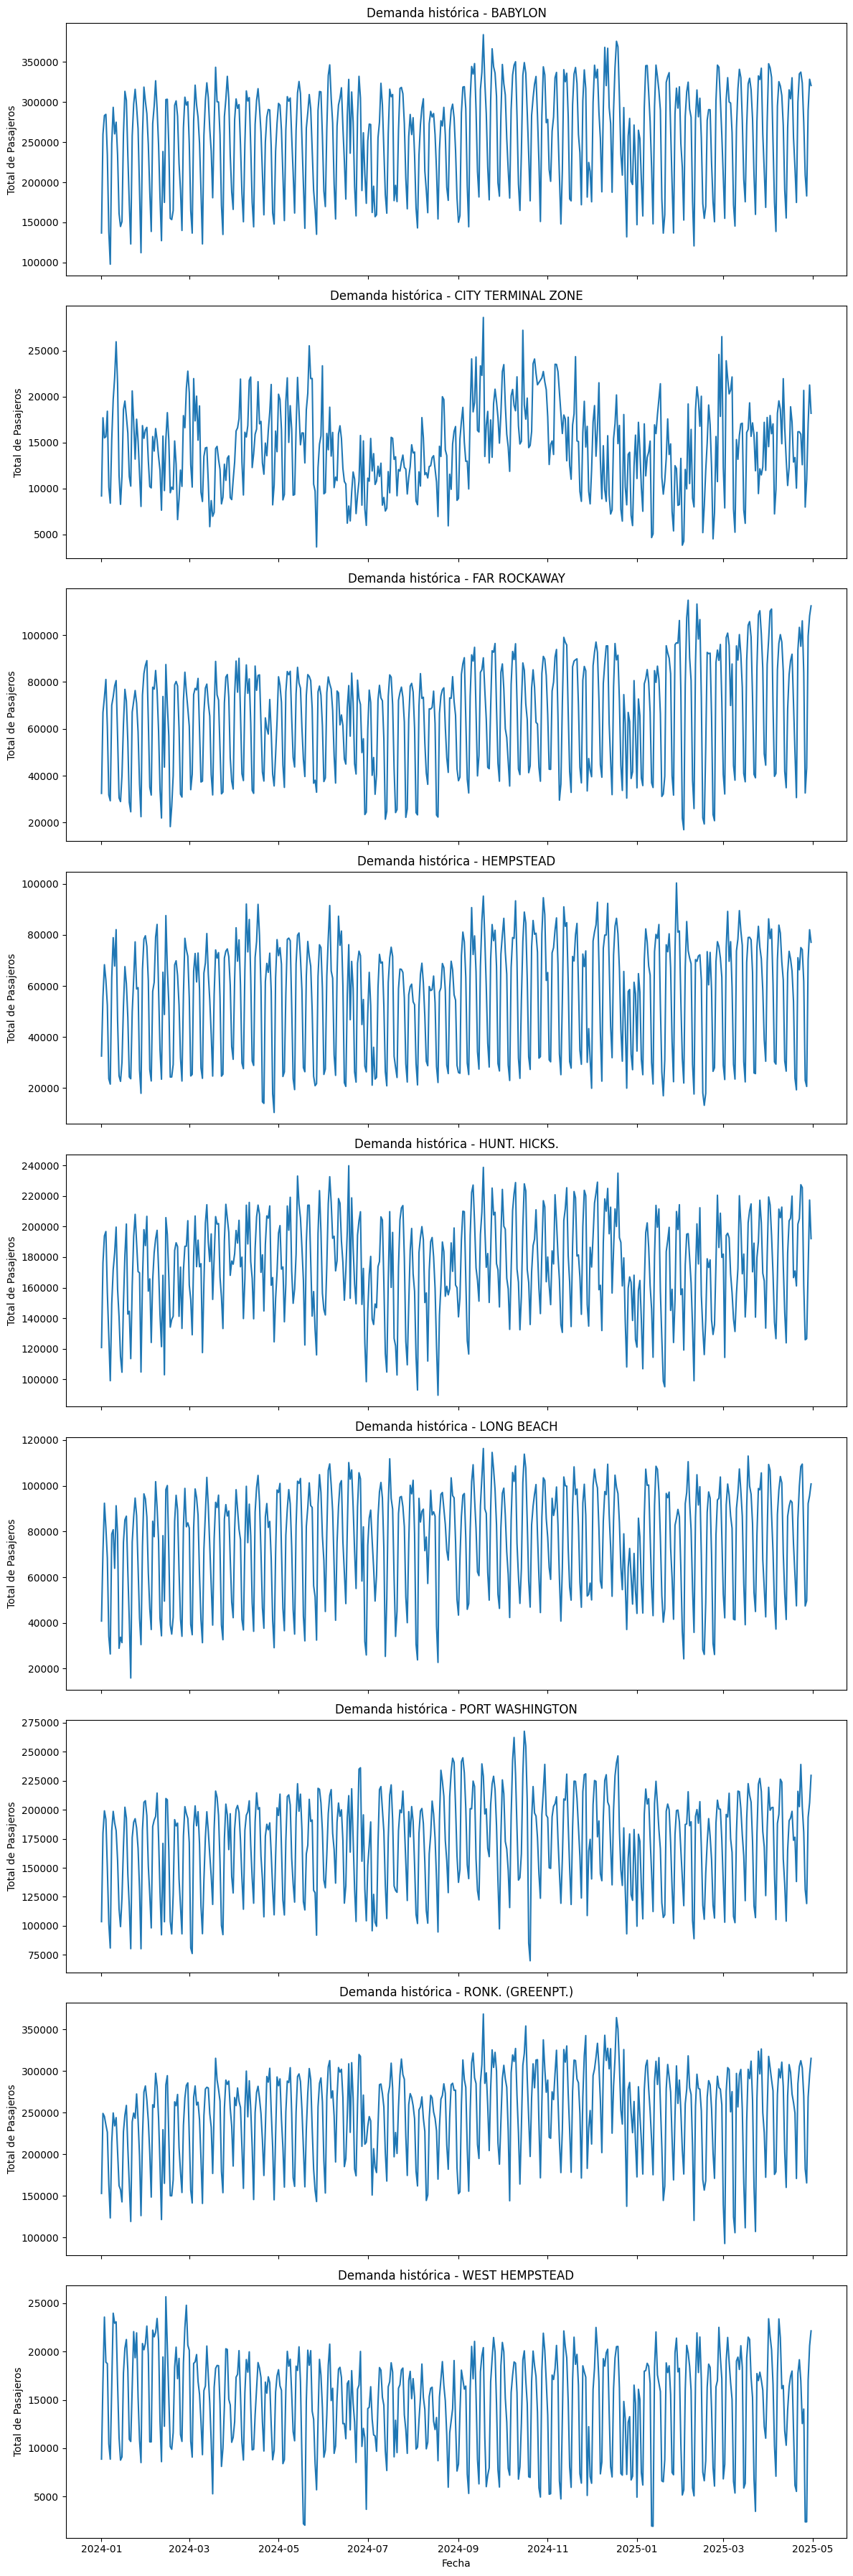

In [25]:
import matplotlib.pyplot as plt

# Número de rutas
routes = df_grouped['Branch Name'].unique()
n_routes = len(routes)

# Crear subplots: uno por ruta (en columna)
fig, axs = plt.subplots(n_routes, 1, figsize=(12, 4 * n_routes), sharex=True)

# Si solo hay una ruta, axs no es un array, lo convertimos a lista
if n_routes == 1:
    axs = [axs]

# Iterar y graficar en cada subplot
for ax, route in zip(axs, routes):
    temp = df_grouped[df_grouped['Branch Name'] == route]
    ax.plot(temp['Service Date'], temp['Total Passengers'])
    ax.set_title(f'Demanda histórica - {route}')
    ax.set_ylabel('Total de Pasajeros')

# Etiqueta común del eje X
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()


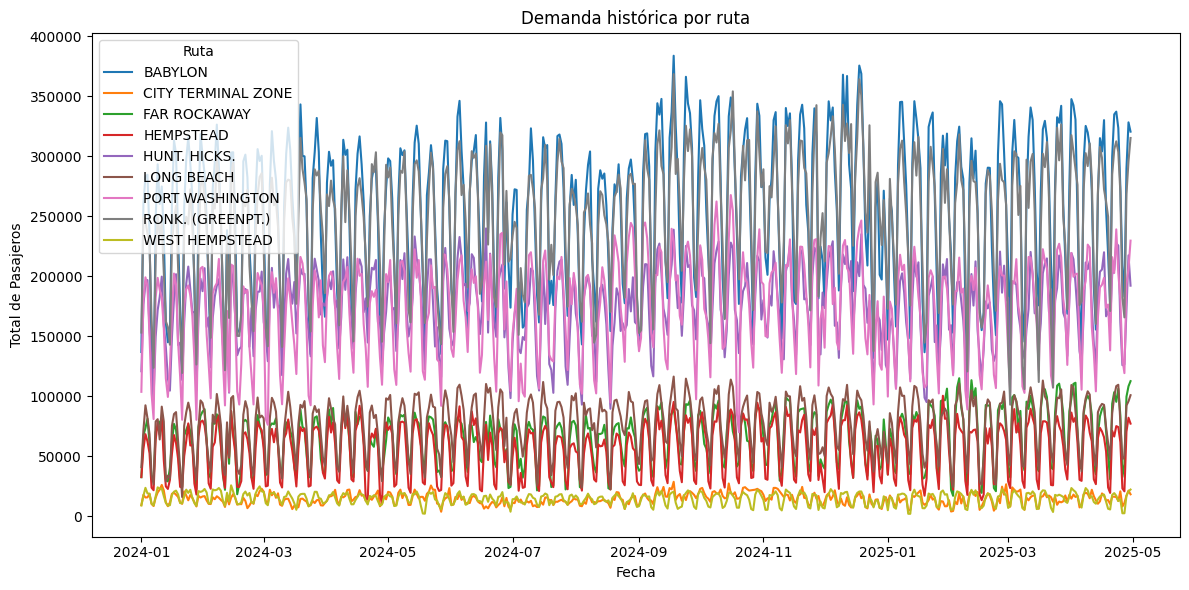

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Tamaño del gráfico

# Iteramos sobre las rutas y graficamos en la misma figura
for route in df_grouped['Branch Name'].unique():
    temp = df_grouped[df_grouped['Branch Name'] == route]
    plt.plot(temp['Service Date'], temp['Total Passengers'], label=route)

# Configuraciones del gráfico
plt.title('Demanda histórica por ruta')
plt.xlabel('Fecha')
plt.ylabel('Total de Pasajeros')
plt.legend(title='Ruta')  # Muestra la leyenda con las rutas
plt.tight_layout()
plt.show()

## Diseño del Modelo

In [26]:
# One-hot encoding del Branch Name
ohe = OneHotEncoder(sparse_output=False)
branch_encoded = ohe.fit_transform(df_grouped[['Branch Name']])

# Agregar los codigos al df_grouped
df_grouped_ohe = df_grouped.copy()
for i, col in enumerate(ohe.get_feature_names_out(['Branch Name'])):
    df_grouped_ohe[col] = branch_encoded[:, i]

# Aseguramos frecuencia diaria por Branch Name
dfs = []
for route in df_grouped['Branch Name'].unique():
    df_r = df_grouped_ohe[df_grouped_ohe['Branch Name'] == route].set_index('Service Date').sort_index()
    df_r = df_r.asfreq('D')
    df_r['Total Passengers'] = df_r['Total Passengers'].fillna(0)  # solo llenar lo numérico
    # Si quieres, también puedes llenar los one-hot con 0:
    ohe_cols = ohe.get_feature_names_out(['Branch Name'])
    df_r[ohe_cols] = df_r[ohe_cols].fillna(0)
    dfs.append(df_r)
df_full = pd.concat(dfs)

# Normalizamos el Total Passengers
scaler = MinMaxScaler()
df_full['Total Passengers'] = scaler.fit_transform(df_full[['Total Passengers']])


In [27]:
df_full

Branch Name  Total Passengers  Branch Name_BABYLON  \
Service Date                                                          
2024-01-01           BABYLON          0.356468                  1.0   
2024-01-02           BABYLON          0.677023                  1.0   
2024-01-03           BABYLON          0.737629                  1.0   
2024-01-04           BABYLON          0.741496                  1.0   
2024-01-05           BABYLON          0.609496                  1.0   
...                      ...               ...                  ...   
2025-04-26    WEST HEMPSTEAD          0.006183                  0.0   
2025-04-27    WEST HEMPSTEAD          0.006196                  0.0   
2025-04-28    WEST HEMPSTEAD          0.044379                  0.0   
2025-04-29    WEST HEMPSTEAD          0.053673                  0.0   
2025-04-30    WEST HEMPSTEAD          0.057704                  0.0   

              Branch Name_CITY TERMINAL ZONE  Branch Name_FAR ROCKAWAY  \
Service Date                                                             
2024-01-01                               0.0                       0.0   
2024-01-02                               0.0                       0.0   
2024-01-03                               0.0                       0.0   
2024-01-04                               0.0                       0.0   
2024-01-05                               0.0                       0.0   
...                                      ...                       ...   
2025-04-26                               0.0                       0.0   
2025-04-27                               0.0                       0.0   
2025-04-28                               0.0                       0.0   
2025-04-29                               0.0                       0.0   
2025-04-30                               0.0                       0.0   

              Branch Name_HEMPSTEAD  Branch Name_HUNT. HICKS.  \
Service Date                                                    
2024-01-01                      0.0                       0.0   
2024-01-02                      0.0                       0.0   
2024-01-03                      0.0                       0.0   
2024-01-04                      0.0                       0.0   
2024-01-05                      0.0                       0.0   
...                             ...                       ...   
2025-04-26                      0.0                       0.0   
2025-04-27                      0.0                       0.0   
2025-04-28                      0.0                       0.0   
2025-04-29                      0.0                       0.0   
2025-04-30                      0.0                       0.0   

              Branch Name_LONG BEACH  Branch Name_PORT WASHINGTON  \
Service Date                                                        
2024-01-01                       0.0                          0.0   
2024-01-02                       0.0                          0.0   
2024-01-03                       0.0                          0.0   
2024-01-04                       0.0                          0.0   
2024-01-05                       0.0                          0.0   
...                              ...                          ...   
2025-04-26                       0.0                          0.0   
2025-04-27                       0.0                          0.0   
2025-04-28                       0.0                          0.0   
2025-04-29                       0.0                          0.0   
2025-04-30                       0.0                          0.0   

              Branch Name_RONK. (GREENPT.)  Branch Name_WEST HEMPSTEAD  
Service Date                                                            
2024-01-01                             0.0                         0.0  
2024-01-02                             0.0                         0.0  
2024-01-03                             0.0                         0.0  
2024-01-04           

In [28]:
df_full.dropna(subset=['Branch Name'], inplace=True)

In [29]:
df_full['Branch Name'].unique()

array(['BABYLON', 'CITY TERMINAL ZONE', 'FAR ROCKAWAY', 'HEMPSTEAD',
       'HUNT. HICKS.', 'LONG BEACH', 'PORT WASHINGTON',
       'RONK. (GREENPT.)', 'WEST HEMPSTEAD'], dtype=object)

In [16]:
def create_multi_sequences(df, seq_length, branch_ohe_cols):
    X_seq = []
    y_seq = []
    for route in df['Branch Name'].unique():
        df_r = df[df['Branch Name'] == route]
        data = df_r['Total Passengers'].values
        branch_ohe = df_r[branch_ohe_cols].values
        for i in range(len(data) - seq_length):
            seq_x_num = data[i:i+seq_length].reshape(seq_length, 1)
            seq_x_cat = np.repeat(branch_ohe[i].reshape(1, -1), seq_length, axis=0)
            seq_x = np.concatenate([seq_x_num, seq_x_cat], axis=1)
            X_seq.append(seq_x)
            y_seq.append(data[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

branch_ohe_cols = ohe.get_feature_names_out(['Branch Name'])
seq_length = 30

X, y = create_multi_sequences(df_full, seq_length, branch_ohe_cols)


In [17]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [18]:
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_torch, y_torch)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [19]:
class MultiRouteRNN(nn.Module):
    def __init__(self, input_size, hidden_dim=50, num_layers=1):
        super(MultiRouteRNN, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.relu(out)
        out = self.fc1(out)
        return out

input_size = 1 + len(branch_ohe_cols)
model = MultiRouteRNN(input_size=input_size, hidden_dim=50)


In [20]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

for epoch in range(num_epochs):
    for xb, yb in loader:
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")


Epoch 1/50, Loss: 0.013110
Epoch 2/50, Loss: 0.009391
Epoch 3/50, Loss: 0.008811
Epoch 4/50, Loss: 0.029124
Epoch 5/50, Loss: 0.031449
Epoch 6/50, Loss: 0.006593
Epoch 7/50, Loss: 0.001859
Epoch 8/50, Loss: 0.005955
Epoch 9/50, Loss: 0.000846
Epoch 10/50, Loss: 0.001112
Epoch 11/50, Loss: 0.002104
Epoch 12/50, Loss: 0.000820
Epoch 13/50, Loss: 0.001626
Epoch 14/50, Loss: 0.036512
Epoch 15/50, Loss: 0.003607
Epoch 16/50, Loss: 0.005213
Epoch 17/50, Loss: 0.000882
Epoch 18/50, Loss: 0.001708
Epoch 19/50, Loss: 0.000621
Epoch 20/50, Loss: 0.001580
Epoch 21/50, Loss: 0.000967
Epoch 22/50, Loss: 0.011718
Epoch 23/50, Loss: 0.001890
Epoch 24/50, Loss: 0.000564
Epoch 25/50, Loss: 0.000077
Epoch 26/50, Loss: 0.003551
Epoch 27/50, Loss: 0.000232
Epoch 28/50, Loss: 0.000384
Epoch 29/50, Loss: 0.001640
Epoch 30/50, Loss: 0.002395
Epoch 31/50, Loss: 0.000292
Epoch 32/50, Loss: 0.004949
Epoch 33/50, Loss: 0.000041
Epoch 34/50, Loss: 0.000975
Epoch 35/50, Loss: 0.000559
Epoch 36/50, Loss: 0.001001
E

In [21]:
# Guardar el estado del modelo
torch.save(model.state_dict(), 'modelo_multiruta_lstm.pt')
print("✅ Modelo guardado en 'modelo_multiruta_lstm.pt'")

✅ Modelo guardado en 'modelo_multiruta_lstm.pt'


## Predicciones

In [22]:
def predict_future(model, initial_seq, branch_ohe, seq_length, scaler, steps=30):
    preds = []
    seq = initial_seq.copy()

    for _ in range(steps):
        input_seq_num = seq.reshape(1, seq_length, 1)
        input_seq_cat = np.repeat(branch_ohe.reshape(1, 1, -1), seq_length, axis=1)
        input_seq = np.concatenate([input_seq_num, input_seq_cat], axis=2)
        input_seq_t = torch.tensor(input_seq, dtype=torch.float32)

        with torch.no_grad():
            pred = model(input_seq_t).item()

        preds.append(pred)
        seq = np.append(seq[1:], pred)

    preds = np.array(preds).reshape(-1,1)

    if scaler is not None:
        preds = scaler.inverse_transform(preds)

    return preds.flatten()



Generando predicción para: BABYLON
Generando predicción para: CITY TERMINAL ZONE
Generando predicción para: FAR ROCKAWAY
Generando predicción para: HEMPSTEAD
Generando predicción para: HUNT. HICKS.
Generando predicción para: LONG BEACH
Generando predicción para: PORT WASHINGTON
Generando predicción para: RONK. (GREENPT.)
Generando predicción para: WEST HEMPSTEAD


g:\Otros ordenadores\DELL\UNAL\SEMESTRES\2025-1\RNAB\Trabajo 3\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
g:\Otros ordenadores\DELL\UNAL\SEMESTRES\2025-1\RNAB\Trabajo 3\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
g:\Otros ordenadores\DELL\UNAL\SEMESTRES\2025-1\RNAB\Trabajo 3\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
g:\Otros ordenadores\DELL\UNAL\SEMESTRES\2025-1\RNAB\Trabajo 3\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
g:\Otros ordenadores\DELL\UNAL\SEMESTRES\2025-1\RNAB\Tra

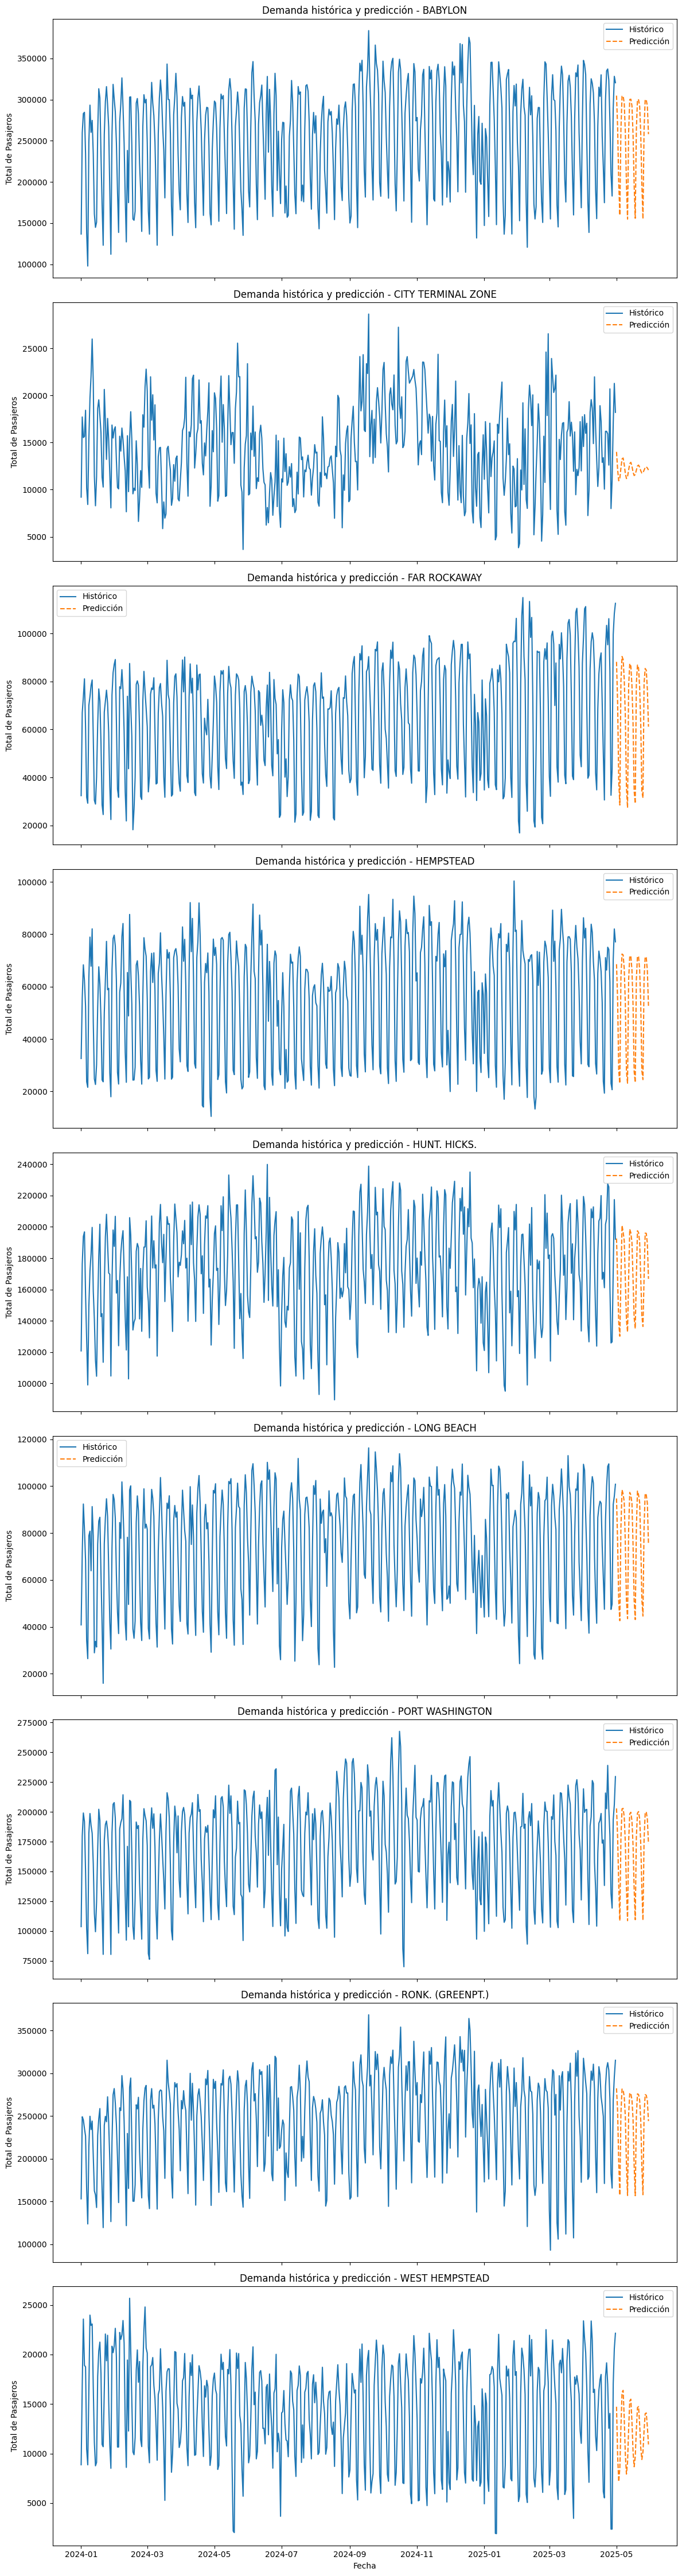

In [30]:
import matplotlib.pyplot as plt

branches = df_full['Branch Name'].unique()
n_branches = len(branches)

fig, axs = plt.subplots(n_branches, 1, figsize=(12, 5 * n_branches), sharex=True)

# Aseguramos que axs sea iterable
if n_branches == 1:
    axs = [axs]

for ax, branch in zip(axs, branches):
    print(f"Generando predicción para: {branch}")

    # Filtramos datos
    df_branch = df_full[df_full['Branch Name'] == branch]
    if len(df_branch) < seq_length:
        print(f"⚠️ No hay suficientes datos para {branch}, se omite.")
        ax.set_title(f'{branch} - Sin datos suficientes')
        continue

    # Última secuencia
    initial_seq = df_branch['Total Passengers'].values[-seq_length:]
    branch_ohe_val = ohe.transform([[branch]]).flatten()

    # Predicción
    preds = predict_future(model, initial_seq, branch_ohe_val, seq_length, scaler)

    # Histórico inverso
    series_inv = scaler.inverse_transform(df_branch['Total Passengers'].values.reshape(-1, 1))

    # Fechas futuras
    future_dates = pd.date_range(df_branch.index[-1] + pd.Timedelta(days=1), periods=30)

    # Graficar
    ax.plot(df_branch.index, series_inv, label='Histórico')
    ax.plot(future_dates, preds, linestyle='--', label='Predicción')
    ax.set_title(f'Demanda histórica y predicción - {branch}')
    ax.set_ylabel('Total de Pasajeros')
    ax.legend()

plt.xlabel('Fecha')
plt.tight_layout()
plt.show()


## Evaluación del modelo


📊 Evaluando backtesting para: BABYLON
RMSE: 20605.11
MAE: 17389.38
BIAS: -11662.50
BIAS %: -4.26%

📊 Evaluando backtesting para: CITY TERMINAL ZONE
RMSE: 4459.44
MAE: 3642.37
BIAS: -2536.71
BIAS %: -16.62%

📊 Evaluando backtesting para: FAR ROCKAWAY
RMSE: 12251.75
MAE: 10114.76
BIAS: -7460.37
BIAS %: -9.43%

📊 Evaluando backtesting para: HEMPSTEAD
RMSE: 5816.71
MAE: 4701.25
BIAS: -2799.93
BIAS %: -4.70%

📊 Evaluando backtesting para: HUNT. HICKS.
RMSE: 14650.95
MAE: 12264.65
BIAS: -4775.43
BIAS %: -2.62%

📊 Evaluando backtesting para: LONG BEACH
RMSE: 6273.15
MAE: 5038.18
BIAS: -1837.03
BIAS %: -2.27%

📊 Evaluando backtesting para: PORT WASHINGTON
RMSE: 16963.58
MAE: 13035.90
BIAS: -5494.76
BIAS %: -3.02%

📊 Evaluando backtesting para: RONK. (GREENPT.)
RMSE: 21788.88
MAE: 18506.46
BIAS: -13123.95
BIAS %: -4.98%

📊 Evaluando backtesting para: WEST HEMPSTEAD
RMSE: 4326.22
MAE: 3692.04
BIAS: -2251.34
BIAS %: -14.98%


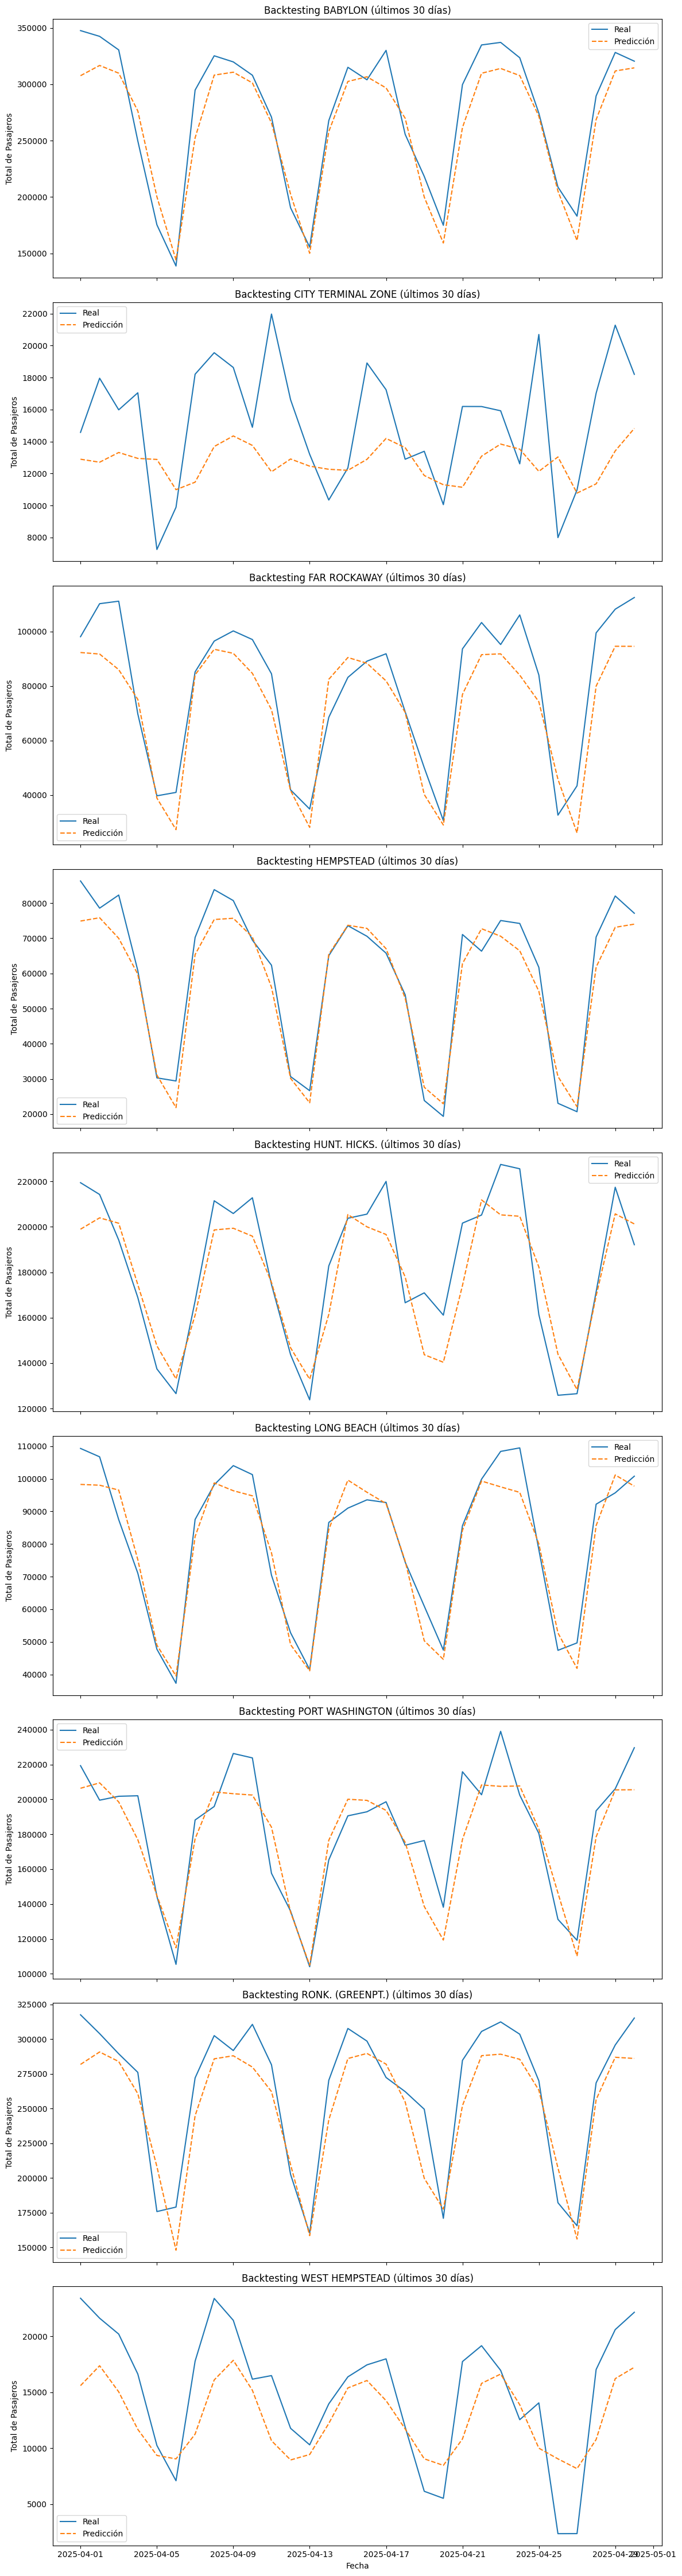

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

branches = df_full['Branch Name'].unique()
n_branches = len(branches)

# Inicializar lista para guardar métricas
metrics = []

# Crear subplots
fig, axs = plt.subplots(n_branches, 1, figsize=(12, 5 * n_branches), sharex=True)

if n_branches == 1:
    axs = [axs]

for ax, branch in zip(axs, branches):
    print(f"\n📊 Evaluando backtesting para: {branch}")

    df_branch = df_full[df_full['Branch Name'] == branch]
    if len(df_branch) < seq_length + 30:
        print(f"⚠️ No hay suficientes datos para {branch}, se omite.")
        ax.set_title(f"{branch} - Sin datos suficientes")
        continue

    series_scaled = df_branch['Total Passengers'].values

    # Dividir en train y test
    test_size = 30
    train_scaled = series_scaled[:-test_size]
    test_scaled = series_scaled[-(test_size + seq_length):]

    # Secuencias test
    X_test, y_test = create_sequences(test_scaled, seq_length)

    branch_ohe_val = ohe.transform(pd.DataFrame([[branch]], columns=['Branch Name'])).flatten()
    branch_ohe_seq = np.repeat(branch_ohe_val.reshape(1, -1), seq_length, axis=0)

    X_test_multi = []
    for x_seq in X_test:
        x_seq_multi = np.concatenate([x_seq.reshape(seq_length,1), branch_ohe_seq], axis=1)
        X_test_multi.append(x_seq_multi)
    X_test_multi = np.array(X_test_multi)

    X_test_torch = torch.tensor(X_test_multi, dtype=torch.float32)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32)

    # Predicciones
    model.eval()
    with torch.no_grad():
        preds_norm = model(X_test_torch).numpy().flatten()

    # Desnormalizar
    preds = scaler.inverse_transform(preds_norm.reshape(-1,1)).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)
    bias = np.mean(preds - y_true)
    bias_pct = 100 * bias / (np.mean(y_true) + 1e-6)

    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"BIAS: {bias:.2f}")
    print(f"BIAS %: {bias_pct:.2f}%")

    # Guardar métricas
    metrics.append({
        'Branch Name': branch,
        'RMSE': rmse,
        'MAE': mae,
        'BIAS': bias,
        'BIAS %': bias_pct
    })

    # Gráfica
    future_dates = df_branch.index[-test_size:]
    ax.plot(future_dates, y_true, label='Real')
    ax.plot(future_dates, preds, linestyle='--', label='Predicción')
    ax.set_title(f'Backtesting {branch} (últimos {test_size} días)')
    ax.set_ylabel('Total de Pasajeros')
    ax.legend()

plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

# Crear DataFrame con métricas
df_metrics = pd.DataFrame(metrics)

# Mostrar las métricas
#import ace_tools as tools; tools.display_dataframe_to_user("Métricas de Backtesting", df_metrics)


In [32]:
df_metrics

Branch Name          RMSE           MAE          BIAS     BIAS %
0             BABYLON  20605.105459  17389.380729 -11662.497396  -4.258872
1  CITY TERMINAL ZONE   4459.438415   3642.368522  -2536.705371 -16.618260
2        FAR ROCKAWAY  12251.752670  10114.755339  -7460.371484  -9.430791
3           HEMPSTEAD   5816.711007   4701.250651  -2799.928255  -4.704476
4        HUNT. HICKS.  14650.945964  12264.654427  -4775.429948  -2.621250
5          LONG BEACH   6273.146832   5038.179297  -1837.030078  -2.268001
6     PORT WASHINGTON  16963.580005  13035.897396  -5494.761979  -3.018848
7    RONK. (GREENPT.)  21788.877484  18506.458854 -13123.949479  -4.983867
8      WEST HEMPSTEAD   4326.215453   3692.039258  -2251.343620 -14.978368

In [34]:
df_metrics.to_csv("backtesting_metrics.csv", index=False)

## Análisis de estacionalidad y tendencias de la demanda

### Semanal


📊 Análisis de estacionalidad y tendencia para: BABYLON


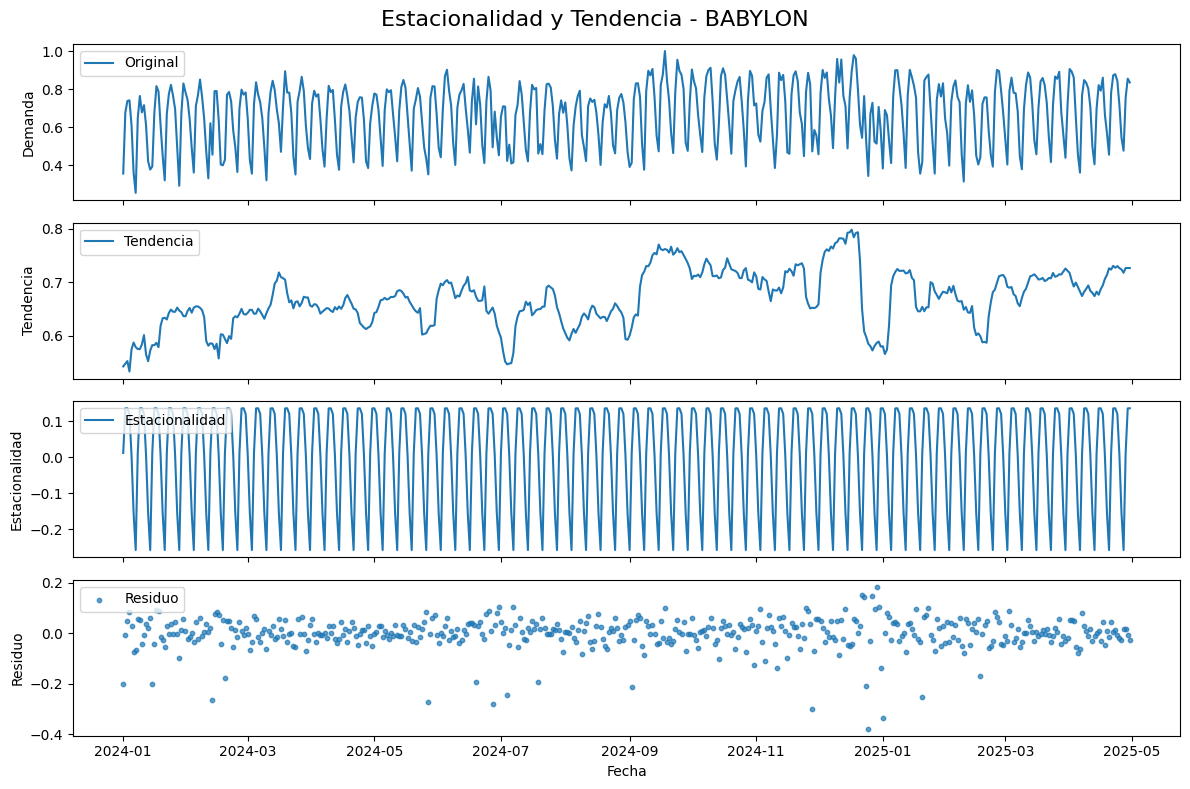


📊 Análisis de estacionalidad y tendencia para: CITY TERMINAL ZONE


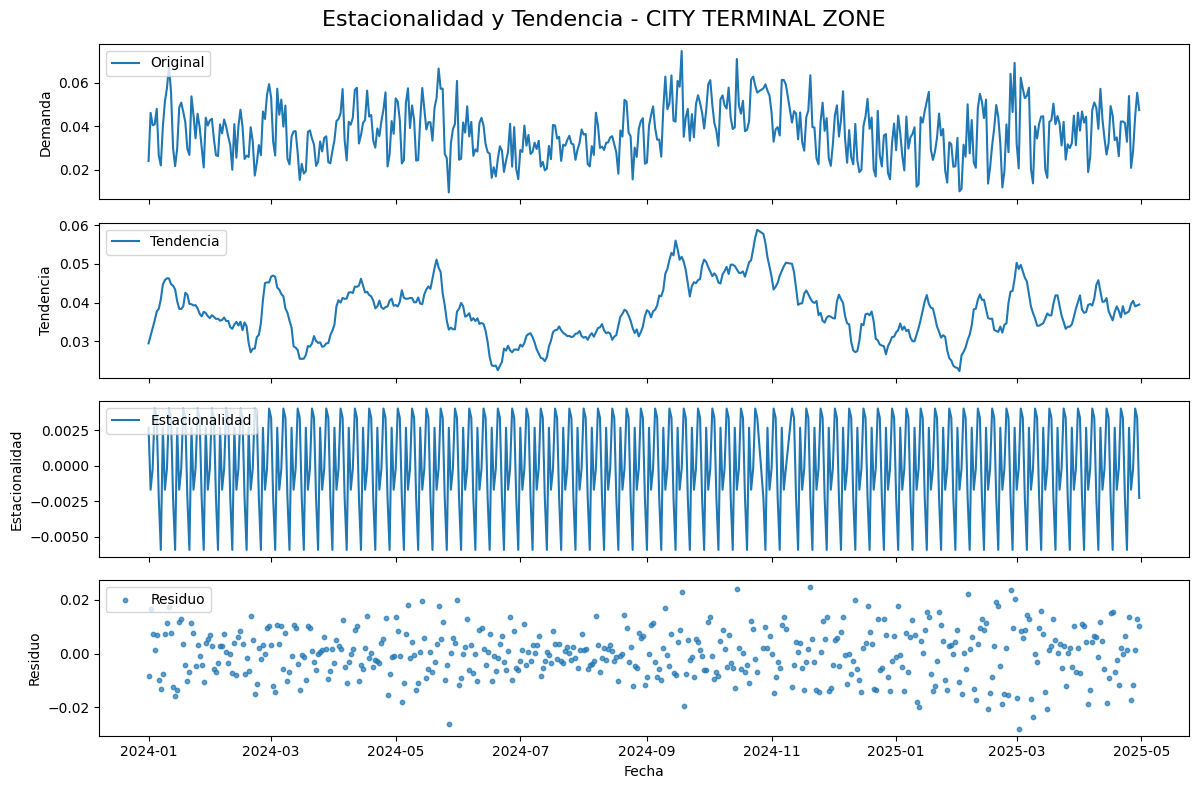


📊 Análisis de estacionalidad y tendencia para: FAR ROCKAWAY


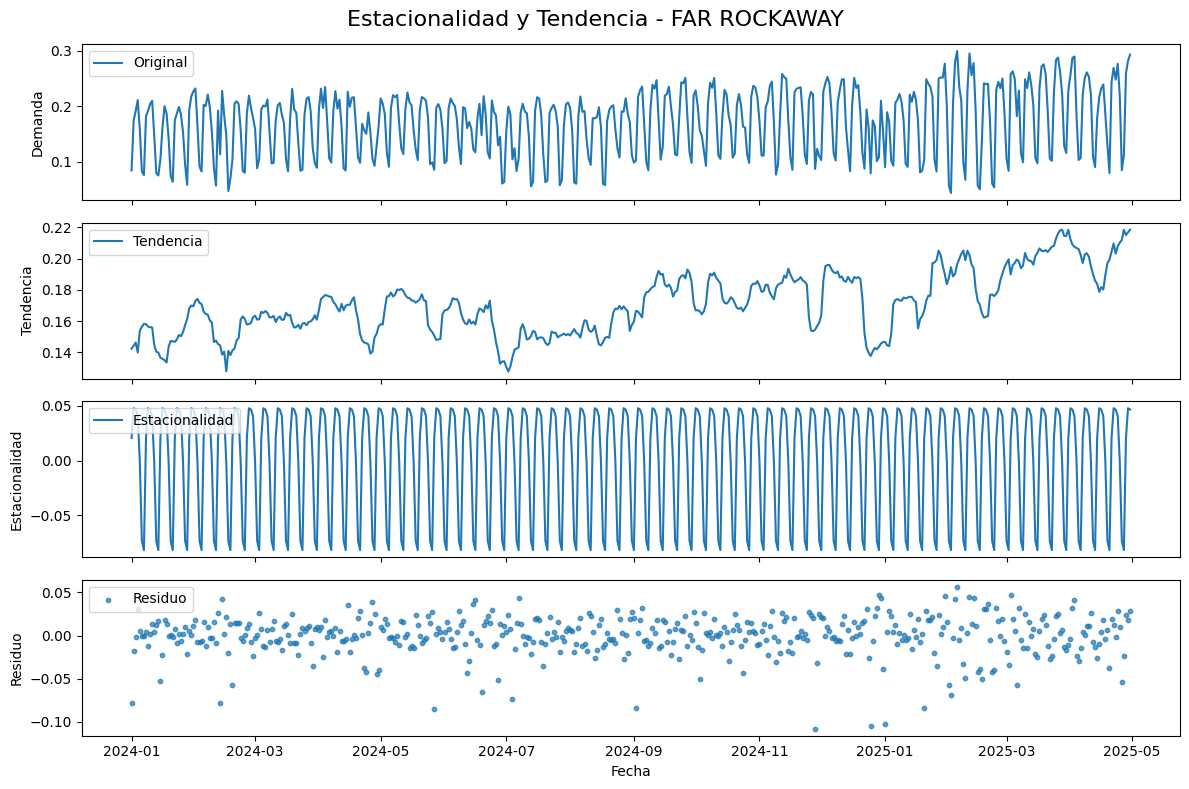


📊 Análisis de estacionalidad y tendencia para: HEMPSTEAD


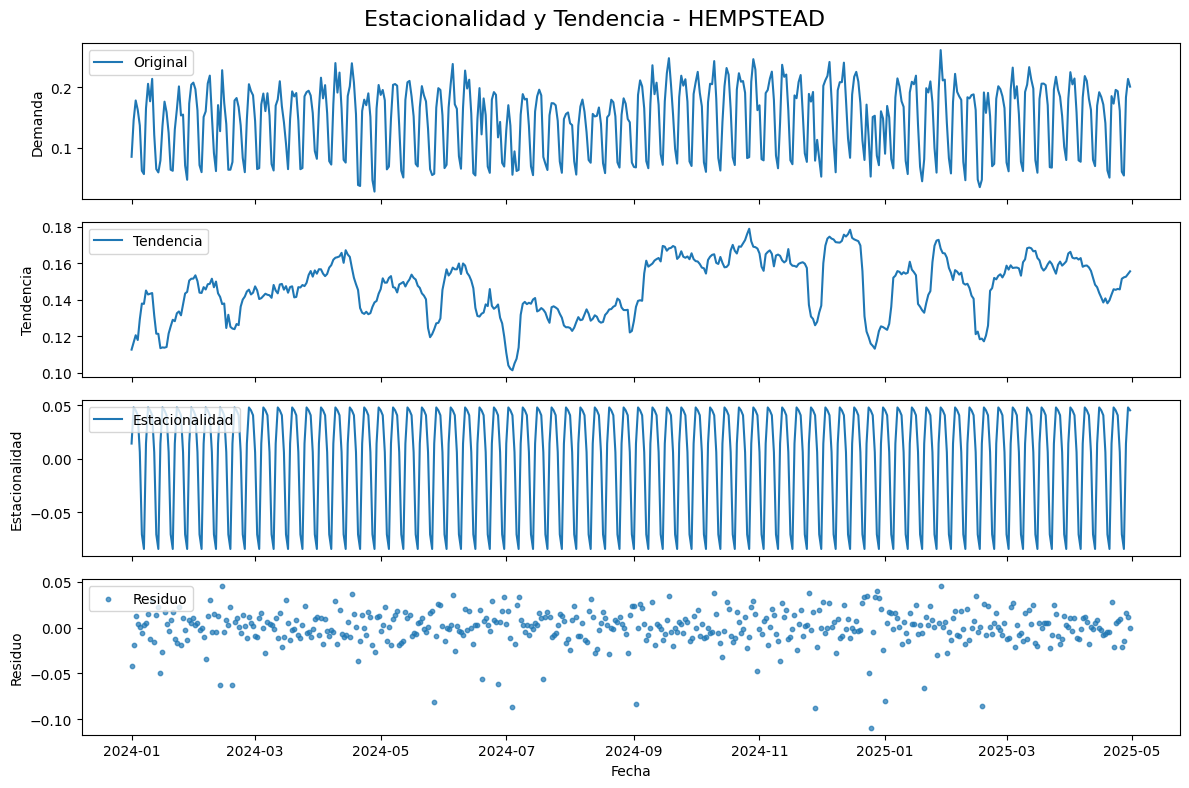


📊 Análisis de estacionalidad y tendencia para: HUNT. HICKS.


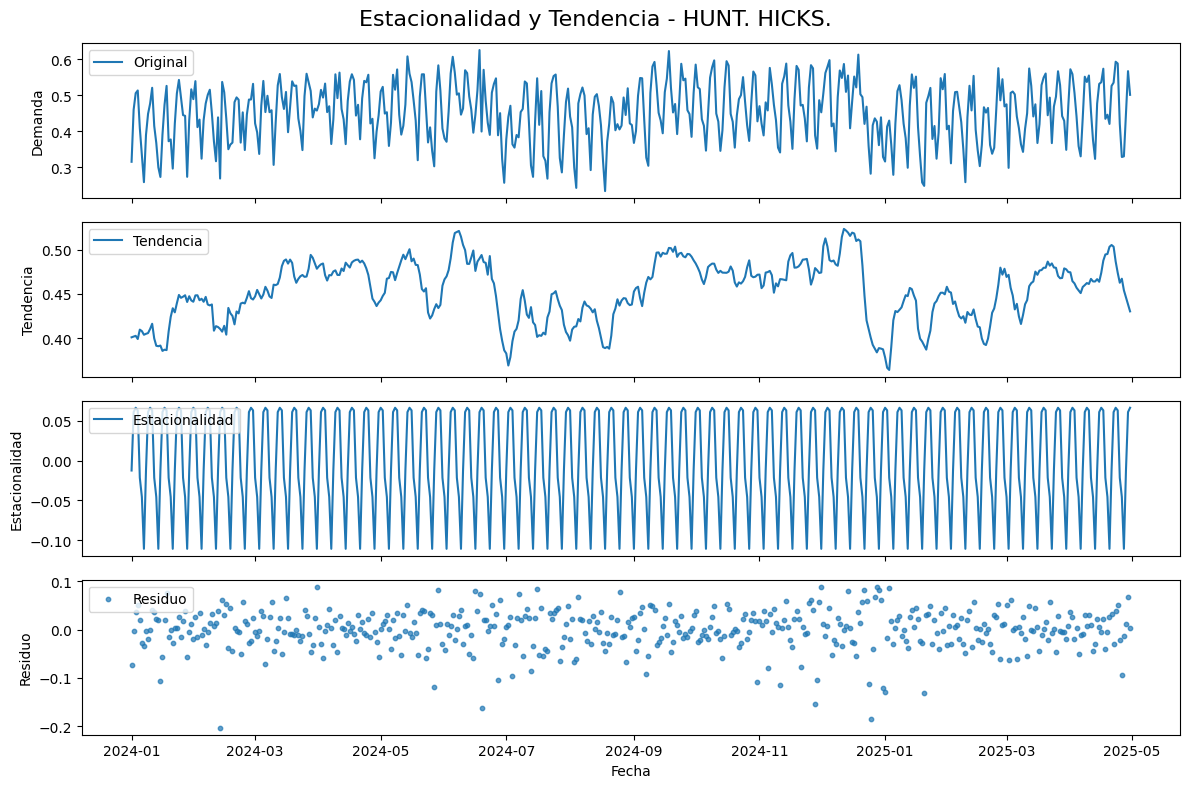


📊 Análisis de estacionalidad y tendencia para: LONG BEACH


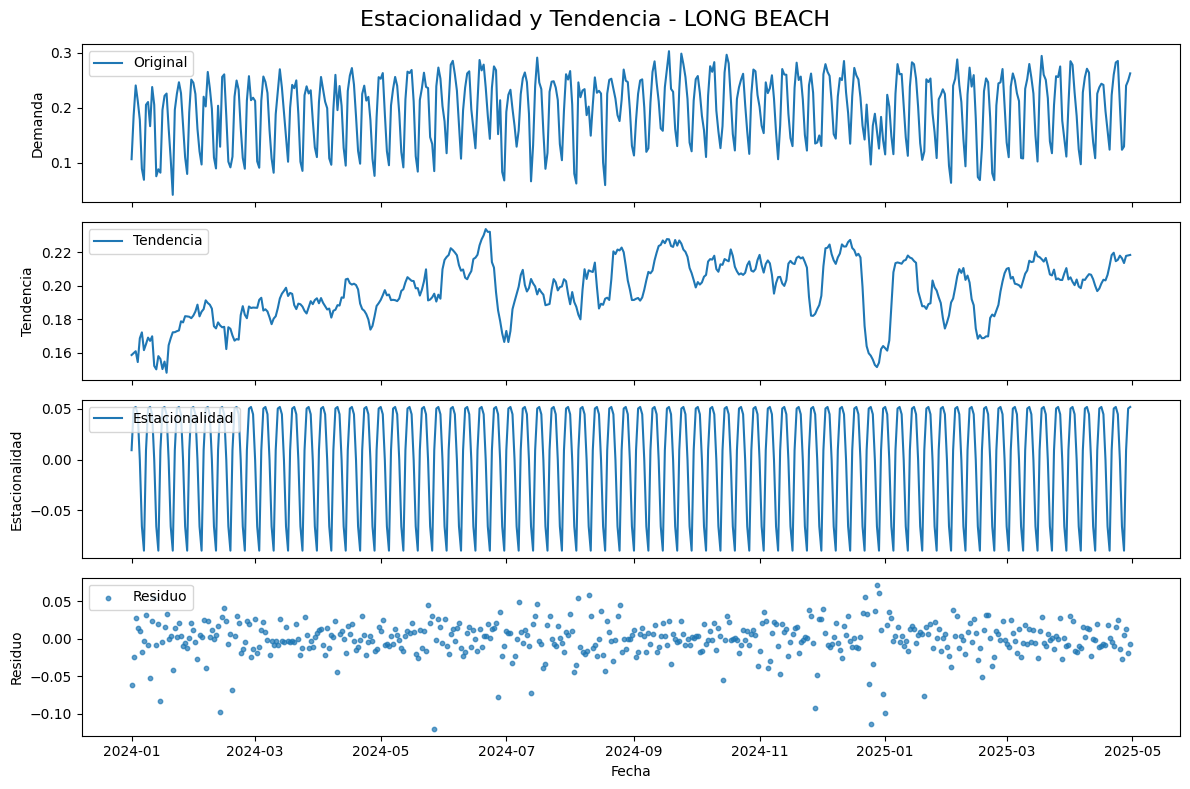


📊 Análisis de estacionalidad y tendencia para: PORT WASHINGTON


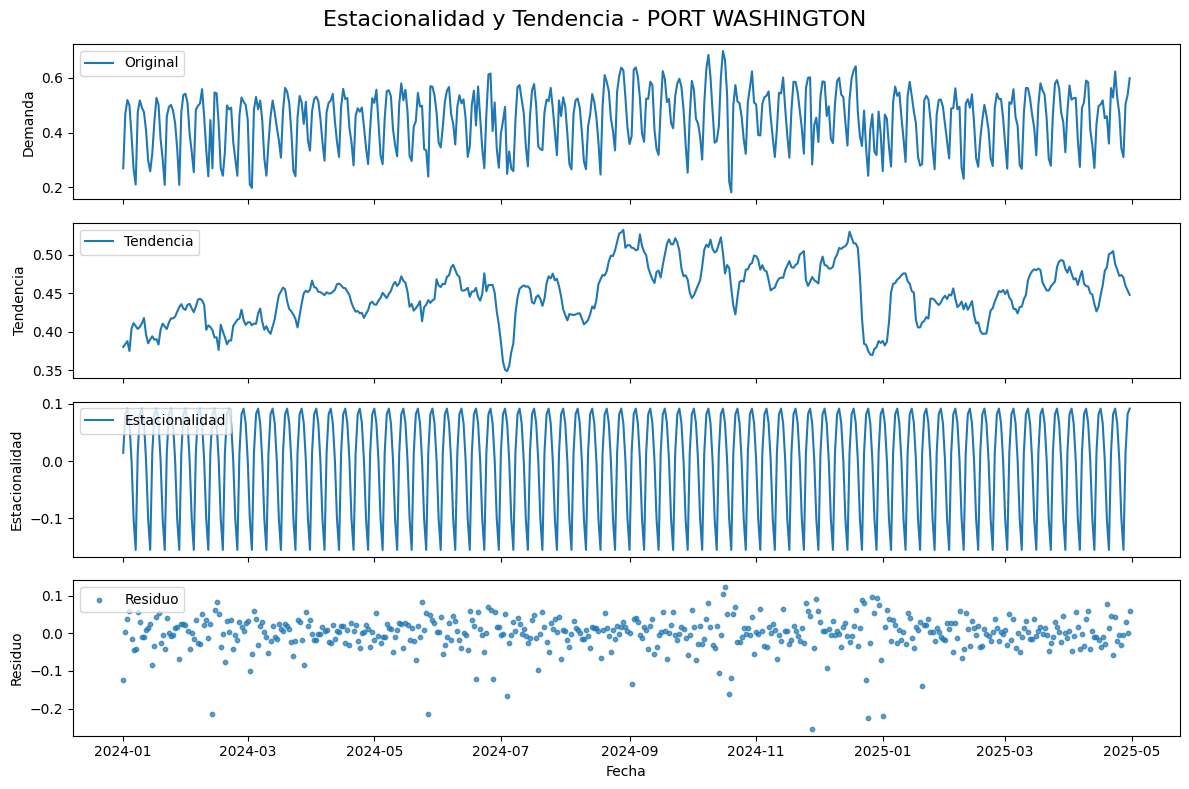


📊 Análisis de estacionalidad y tendencia para: RONK. (GREENPT.)


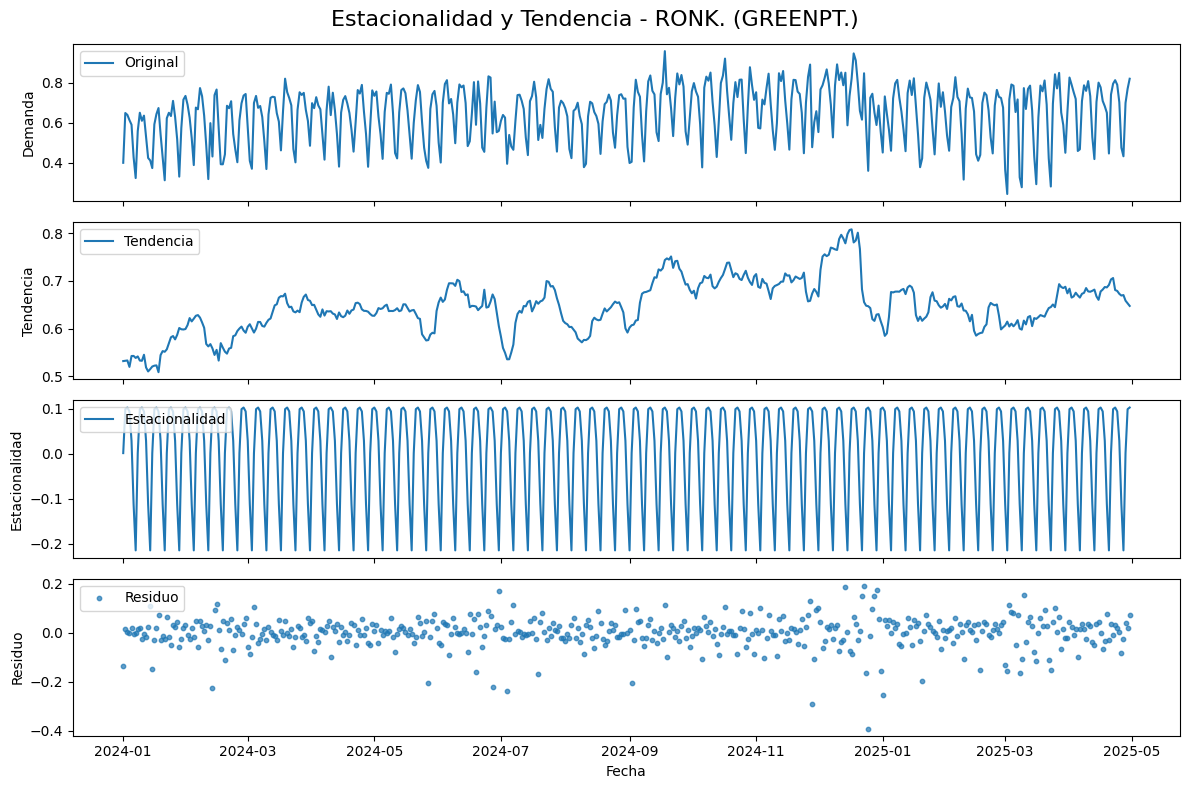


📊 Análisis de estacionalidad y tendencia para: WEST HEMPSTEAD


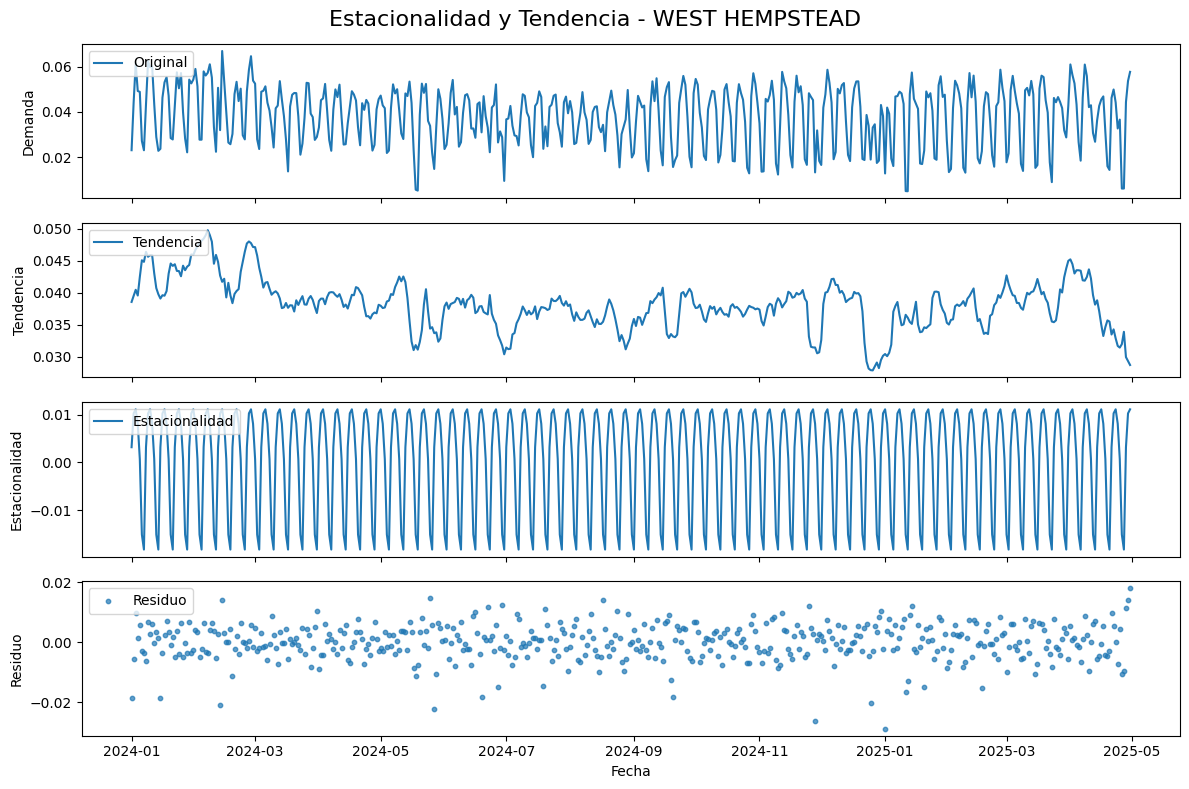

In [33]:
for branch in df_full['Branch Name'].unique():
    print(f"\n📊 Análisis de estacionalidad y tendencia para: {branch}")

    df_branch = df_full[df_full['Branch Name'] == branch]
    series = df_branch['Total Passengers']

    if len(series) < 60:
        print(f"⚠️ No hay suficientes datos para analizar la estacionalidad de {branch}.")
        continue

    result = seasonal_decompose(series, model='additive', period=7, extrapolate_trend='freq')

    # Graficar con subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

    # Original
    axes[0].plot(series.index, series, label='Original')
    axes[0].legend(loc='upper left')
    axes[0].set_ylabel('Demanda')

    # Tendencia
    axes[1].plot(series.index, result.trend, label='Tendencia')
    axes[1].legend(loc='upper left')
    axes[1].set_ylabel('Tendencia')

    # Estacionalidad
    axes[2].plot(series.index, result.seasonal, label='Estacionalidad')
    axes[2].legend(loc='upper left')
    axes[2].set_ylabel('Estacionalidad')

    # Residuo
    axes[3].scatter(series.index, result.resid, s=10, alpha=0.7, label='Residuo')
    axes[3].legend(loc='upper left')
    axes[3].set_ylabel('Residuo')

    plt.xlabel('Fecha')
    plt.suptitle(f'Estacionalidad y Tendencia - {branch}', fontsize=16)
    plt.tight_layout()
    plt.show()


### Mensual


📊 Análisis de estacionalidad y tendencia para: BABYLON


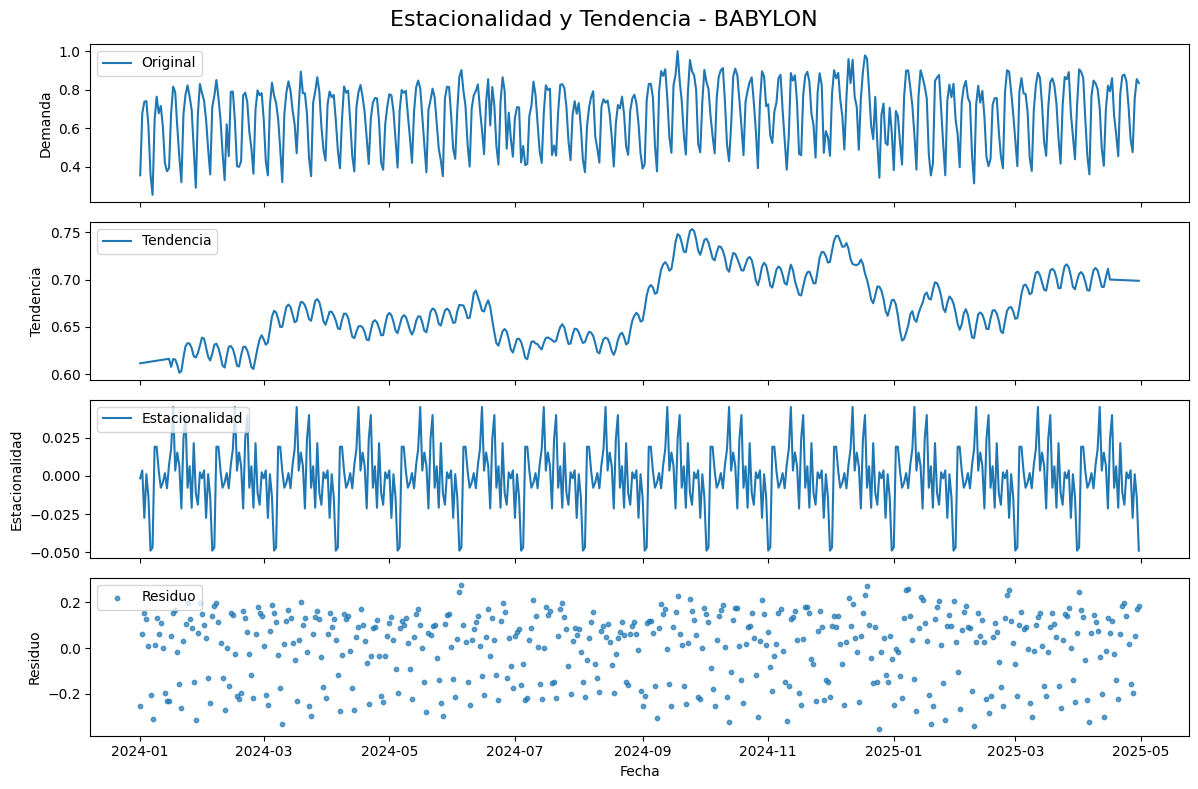


📊 Análisis de estacionalidad y tendencia para: CITY TERMINAL ZONE


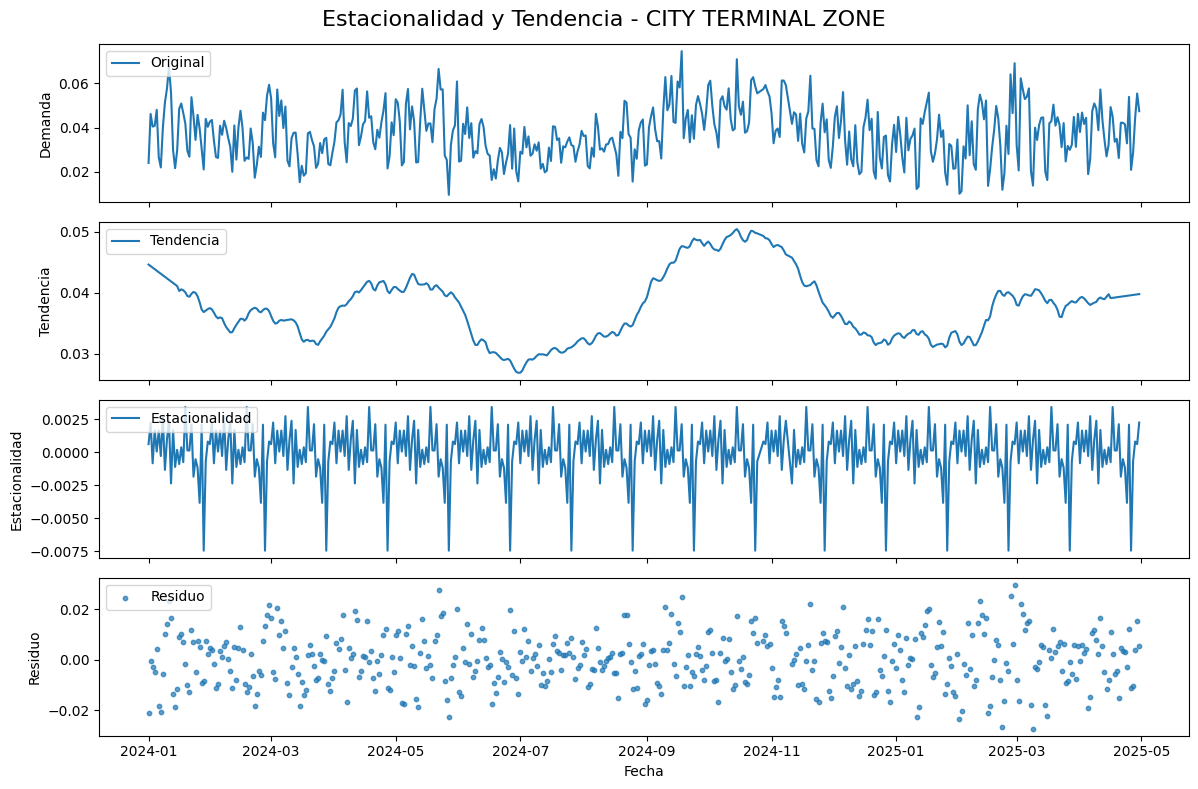


📊 Análisis de estacionalidad y tendencia para: FAR ROCKAWAY


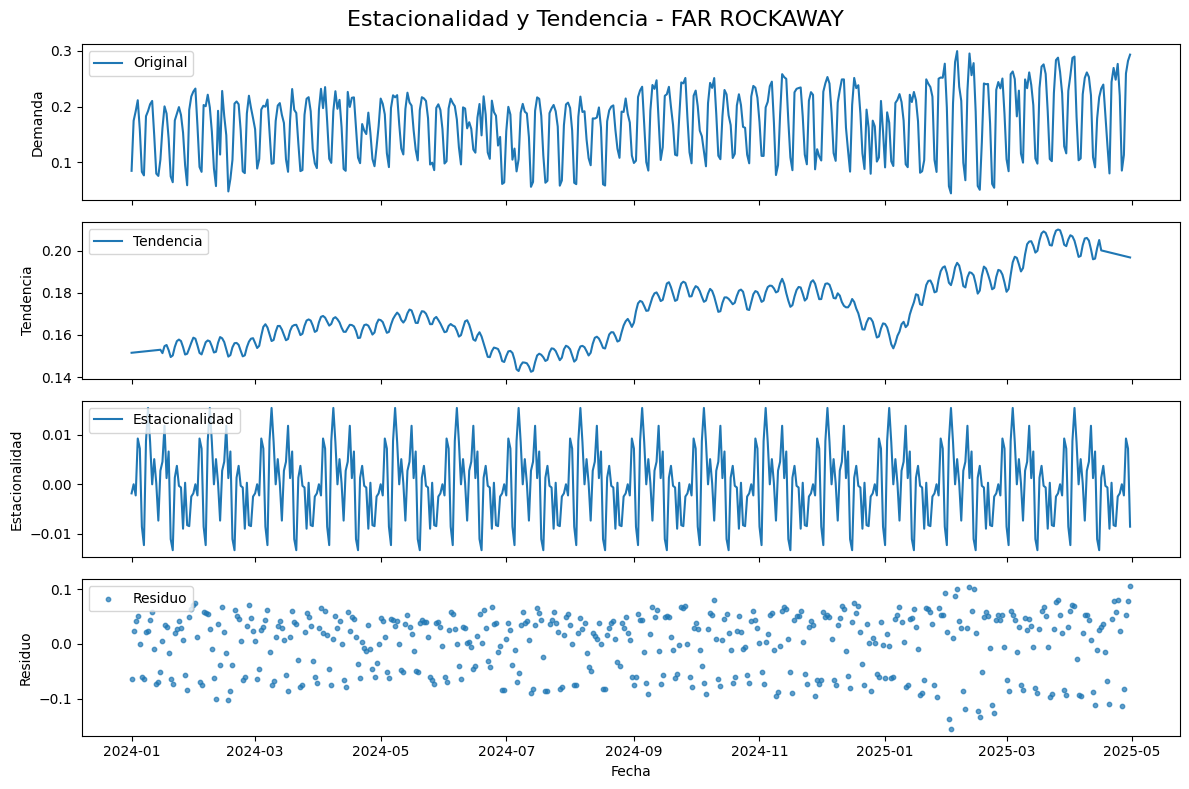


📊 Análisis de estacionalidad y tendencia para: HEMPSTEAD


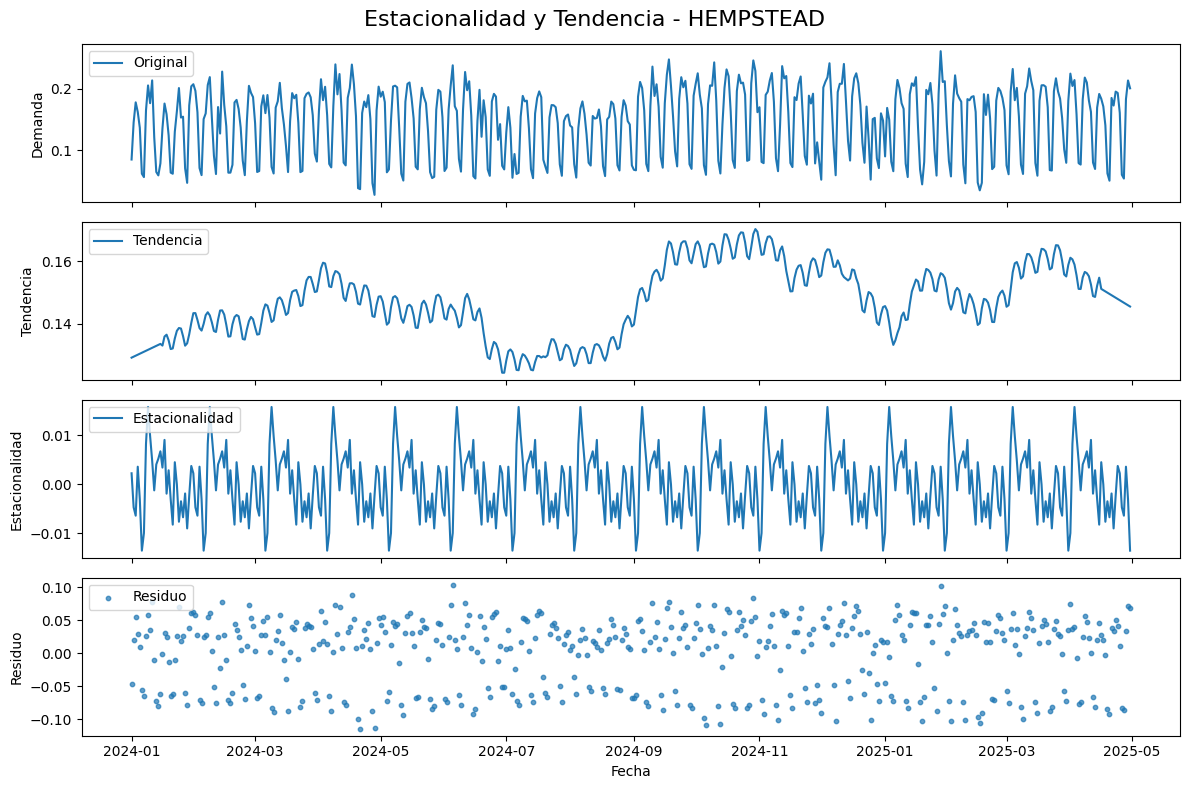


📊 Análisis de estacionalidad y tendencia para: HUNT. HICKS.


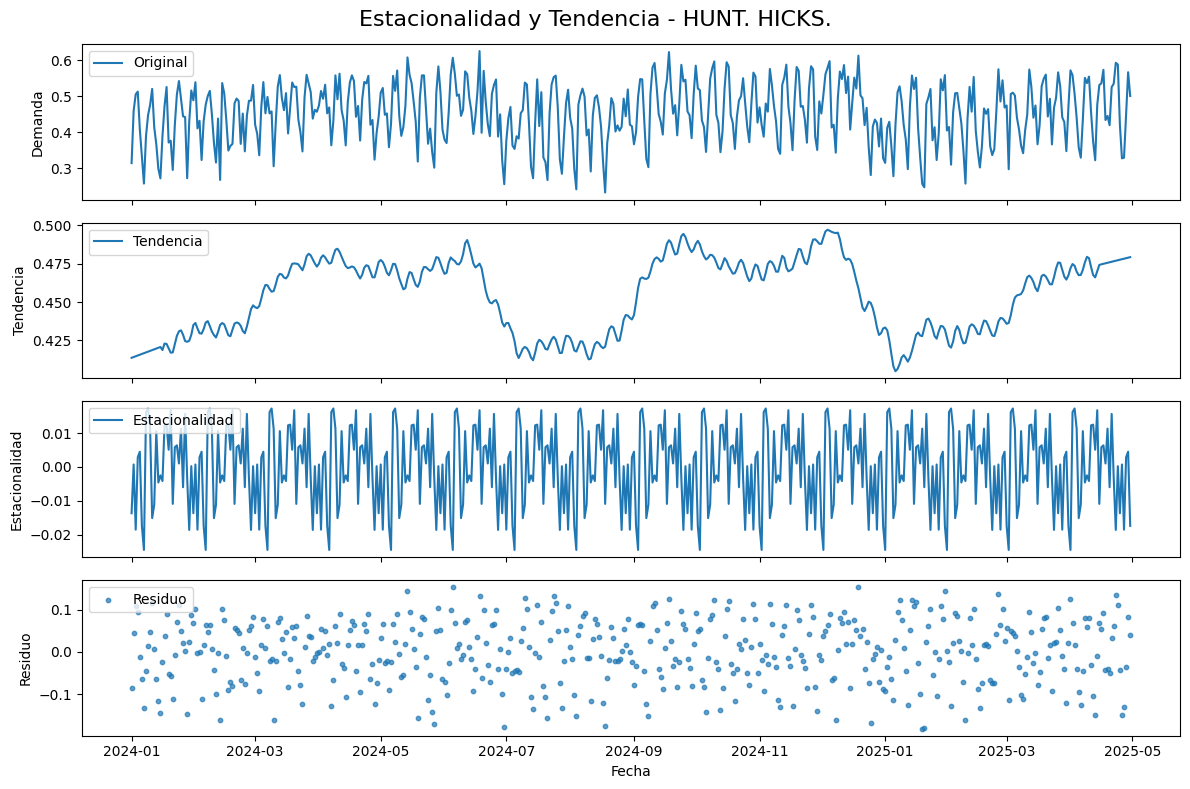


📊 Análisis de estacionalidad y tendencia para: LONG BEACH


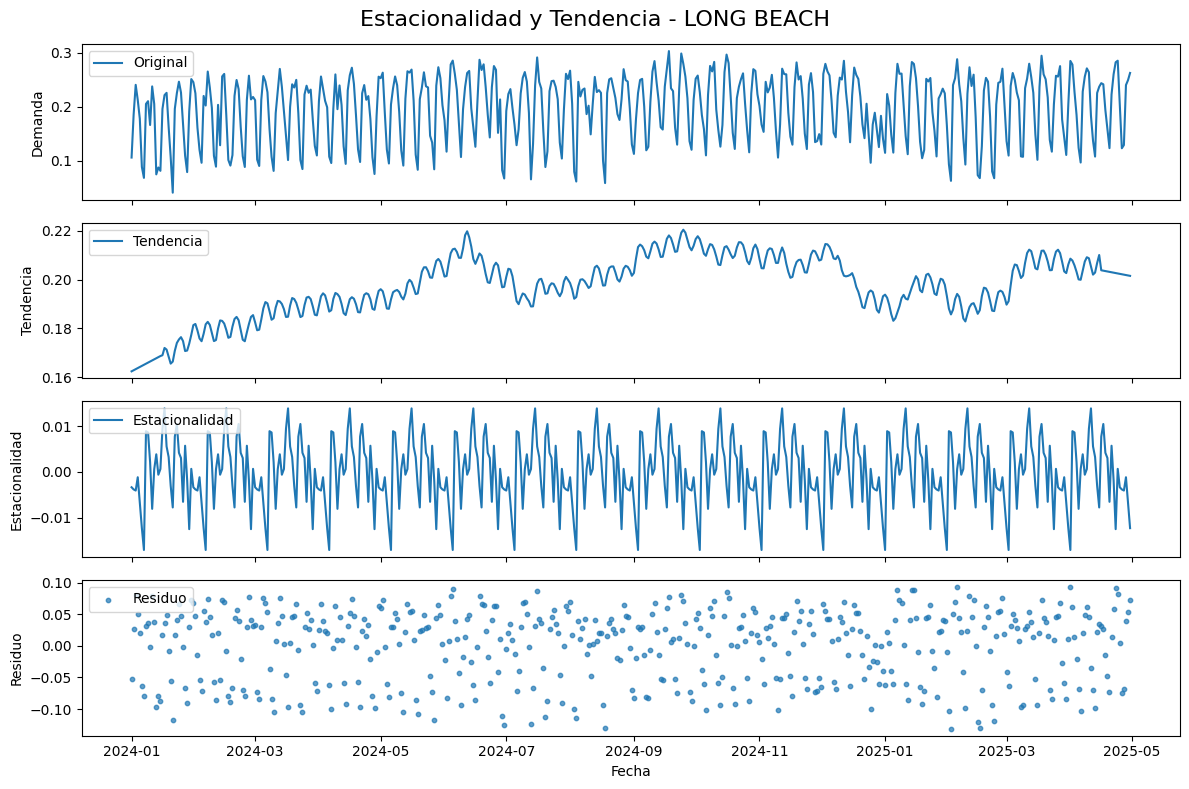


📊 Análisis de estacionalidad y tendencia para: PORT WASHINGTON


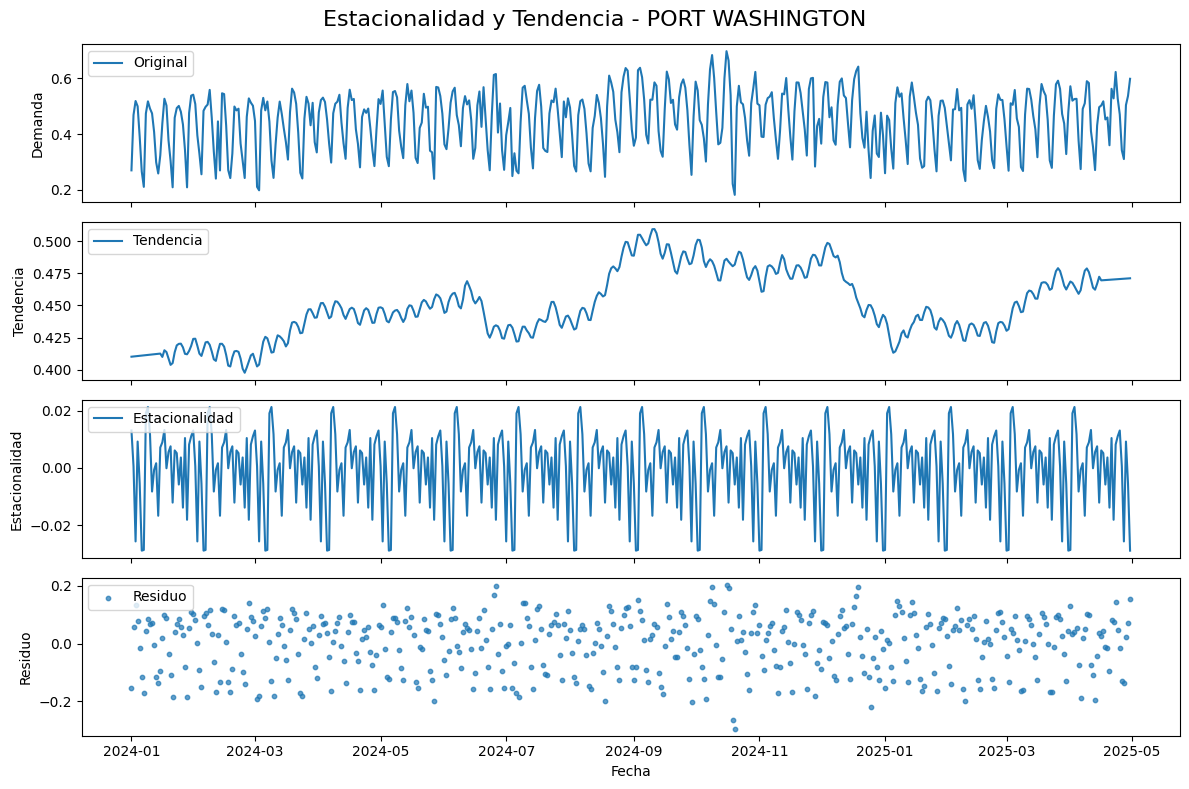


📊 Análisis de estacionalidad y tendencia para: RONK. (GREENPT.)


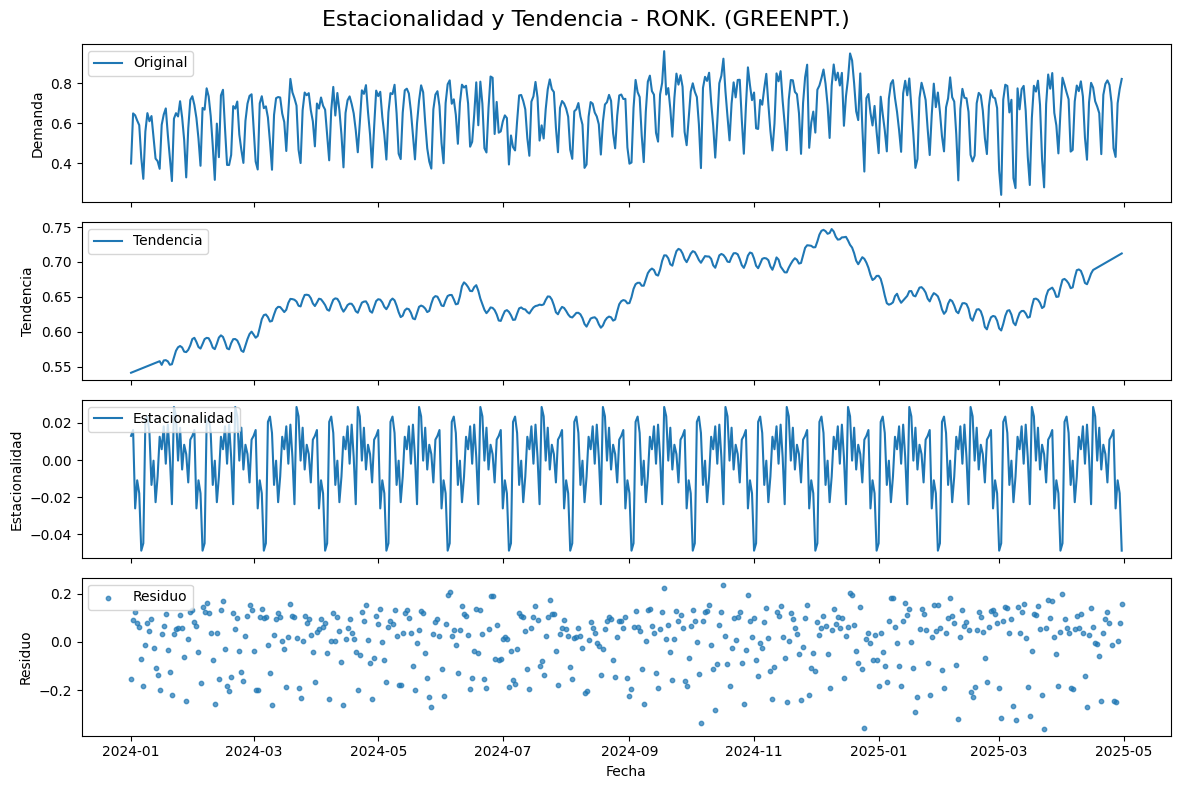


📊 Análisis de estacionalidad y tendencia para: WEST HEMPSTEAD


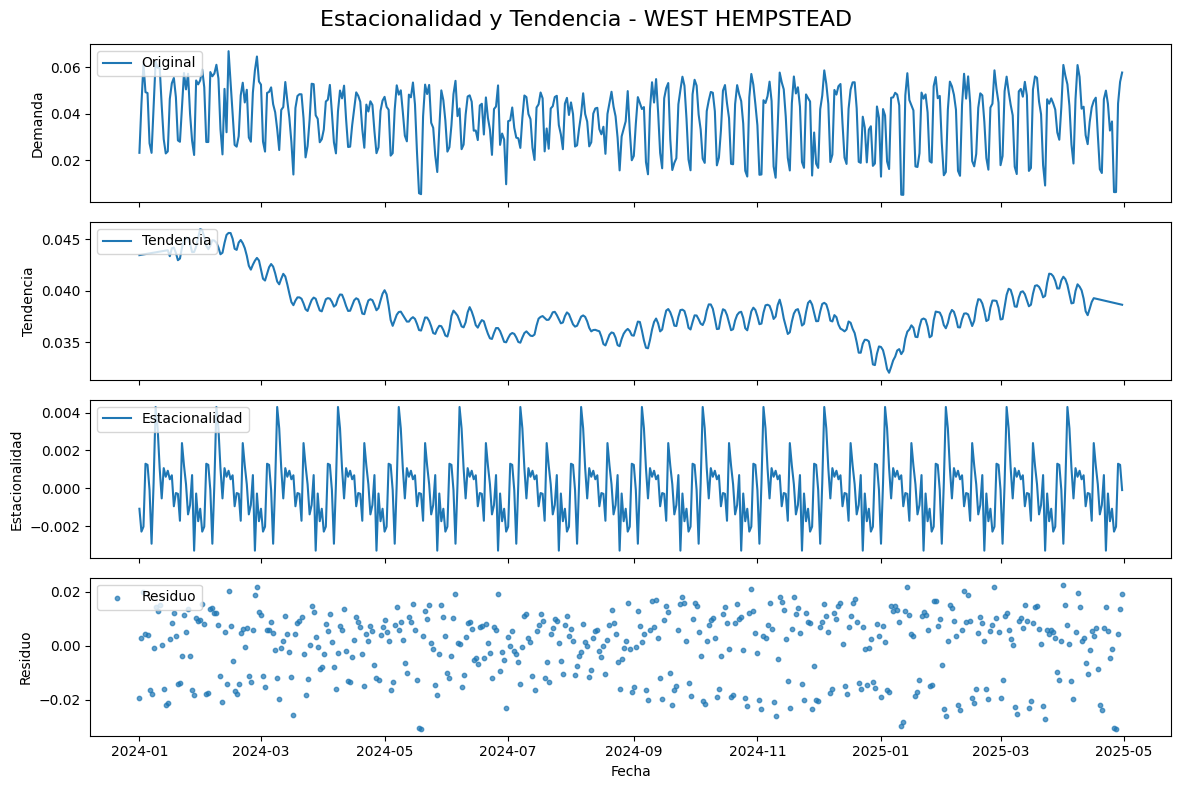

In [35]:
for branch in df_full['Branch Name'].unique():
    print(f"\n📊 Análisis de estacionalidad y tendencia para: {branch}")

    df_branch = df_full[df_full['Branch Name'] == branch]
    series = df_branch['Total Passengers']

    if len(series) < 60:
        print(f"⚠️ No hay suficientes datos para analizar la estacionalidad de {branch}.")
        continue

    result = seasonal_decompose(series, model='additive', period=30, extrapolate_trend='freq')

    # Graficar con subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

    # Original
    axes[0].plot(series.index, series, label='Original')
    axes[0].legend(loc='upper left')
    axes[0].set_ylabel('Demanda')

    # Tendencia
    axes[1].plot(series.index, result.trend, label='Tendencia')
    axes[1].legend(loc='upper left')
    axes[1].set_ylabel('Tendencia')

    # Estacionalidad
    axes[2].plot(series.index, result.seasonal, label='Estacionalidad')
    axes[2].legend(loc='upper left')
    axes[2].set_ylabel('Estacionalidad')

    # Residuo
    axes[3].scatter(series.index, result.resid, s=10, alpha=0.7, label='Residuo')
    axes[3].legend(loc='upper left')
    axes[3].set_ylabel('Residuo')

    plt.xlabel('Fecha')
    plt.suptitle(f'Estacionalidad y Tendencia - {branch}', fontsize=16)
    plt.tight_layout()
    plt.show()